In [1]:
!pip -q install scikit-image scipy

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files

# ✅ 최신 API에 맞춘 import
from skimage.filters import threshold_otsu
from skimage.morphology import (
    opening, remove_small_objects, binary_dilation, disk,
    footprint_rectangle,   # ← rectangle 대체
)

➡️ 리사주 이미지 1장을 업로드하세요(.png/.jpg)


Saving sample lissajous picture.PNG to sample lissajous picture.PNG


/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 47532 (\N{HANGUL SYLLABLE RI}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout(); plt.show()
/tmp/ipython-input-3205435894.py:44: UserWarning: Glyph 44201 (\N{HANGUL 

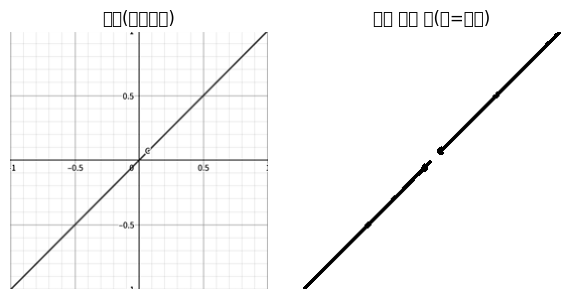

In [35]:
# 0) 업로드 + 격자 제거 전처리
def remove_grid_from_pil(pil_img, side=256, h_scale=12, min_obj=150, dilate_px=1):
    """
    흑백·리사이즈 → 이진화 → 수평/수직 격자 제거 → 작은 잡음 제거 → (옵션)선 굵게 → 0/255 반환
    """
    img = pil_img.convert('L').resize((side, side), Image.BILINEAR)
    arr = np.array(img)

    # 어두운 선 기준 이진화
    th = threshold_otsu(arr)
    binary = arr < th  # True = 선

    # ✅ footprint_rectangle에 튜플로 인자 전달
    h_len = max(8, side // h_scale)
    grid_h = opening(binary, footprint=footprint_rectangle((1, h_len)))   # ───
    grid_v = opening(binary, footprint=footprint_rectangle((h_len, 1)))   # │
    grid = np.logical_or(grid_h, grid_v)

    # 격자 제거 + 잡음 제거 + (옵션)선 굵게
    curve_only = np.logical_and(binary, np.logical_not(grid))
    curve_only = remove_small_objects(curve_only, min_size=min_obj)
    if dilate_px > 0:
        curve_only = binary_dilation(curve_only, footprint=disk(dilate_px))

    # 렌더러와 동일 극성: 선=0, 배경=255
    out = np.ones_like(arr, dtype=np.uint8) * 255
    out[curve_only] = 0
    return out


# ===== 업로드 및 전처리 =====
print("➡️ 리사주 이미지 1장을 업로드하세요(.png/.jpg)")
uploaded = files.upload()
fname = next(iter(uploaded))

SIDE = 256
orig = Image.open(fname)
target_img = remove_grid_from_pil(orig, side=SIDE, h_scale=12, min_obj=150, dilate_px=1)

# 미리보기
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(orig.convert('L').resize((SIDE,SIDE)), cmap='gray'); plt.title("원본(리사이즈)"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(target_img, cmap='gray'); plt.title("격자 제거 후(선=검정)"); plt.axis('off')
plt.tight_layout(); plt.show()

In [36]:
# 1) Lissajous (delta = 0)
def lissajous(a, b, n=2400, tmax=2*np.pi):
    t = np.linspace(0, tmax, n)
    x = np.sin(a*t)   # delta=0 고정
    y = np.sin(b*t)
    return x, y

In [37]:
# 2) 곡선을 흑백 이미지로 래스터화 (얇은 폴리라인)
def render_curve_image(x, y, size=256, margin=0.06):
    x = x / (np.max(np.abs(x)) + 1e-9)
    y = y / (np.max(np.abs(y)) + 1e-9)
    img = np.ones((size, size), dtype=np.uint8) * 255  # white bg

    s = int(size*(1-2*margin))
    px = ((x+1)/2 * s + size*margin).astype(int)
    py = ((1-(y+1)/2) * s + size*margin).astype(int)

    # Bresenham polyline
    def line_pixels(r0, c0, r1, c1):
        rr, cc = [], []
        dr = abs(r1 - r0); dc = abs(c1 - c0)
        sr = 1 if (r1 - r0) >= 0 else -1
        sc = 1 if (c1 - c0) >= 0 else -1
        if dc > dr:
            err = dc // 2; r = r0
            for c in range(c0, c1+sc, sc):
                if 0<=r<size and 0<=c<size: rr.append(r); cc.append(c)
                err -= dr
                if err < 0: r += sr; err += dc
        else:
            err = dr // 2; c = c0
            for r in range(r0, r1+sr, sr):
                if 0<=r<size and 0<=c<size: rr.append(r); cc.append(c)
                err -= dc
                if err < 0: c += sc; err += dr
        return np.array(rr), np.array(cc)

    for i in range(1, len(px)):
        rr, cc = line_pixels(py[i-1], px[i-1], py[i], px[i])
        img[rr, cc] = 0
    return img

def draw_lissajous_image(a, b, size=256, tmax=2*np.pi):
    x, y = lissajous(a, b, n=2400, tmax=tmax)
    return render_curve_image(x, y, size=size)

In [38]:
# 3) 회전/스왑 동형성 고려한 SSIM
def rotate_points(x, y, theta):
    c, s = np.cos(theta), np.sin(theta)
    xr = c*x - s*y
    yr = s*x + c*y
    return xr, yr

def best_ssim_to_target(a, b, target_img, try_rotations=True, try_swap=True, tmax=2*np.pi):
    angles = np.linspace(0, np.pi, 13) if try_rotations else [0.0]
    pairs = [(a,b)]
    if try_swap:
        pairs.append((b,a))  # (a,b)와 (b,a)는 회전/대칭으로 동형

    best = -1.0
    for aa, bb in pairs:
        x, y = lissajous(aa, bb, n=2400, tmax=tmax)
        for th in angles:
            xr, yr = rotate_points(x, y, th)
            cand = render_curve_image(xr, yr, size=target_img.shape[0])
            score = ssim(target_img, cand)
            if score > best:
                best = score
    return best

In [39]:
# 4) 정수비 coarse 탐색 (δ=0)
def coarse_integer_search_delta0(target_img, a_max=12, b_max=12, tmax=2*np.pi):
    best = {'score':-1, 'a':None, 'b':None}
    for a in range(1, a_max+1):
        for b in range(1, b_max+1):
            s = best_ssim_to_target(a, b, target_img, try_rotations=True, try_swap=True, tmax=tmax)
            if s > best['score']:
                best.update({'score':s, 'a':a, 'b':b})
    return best

In [40]:
# 5) (a,b) 연속 최적화 (δ=0)
def refine_ab_delta0(target_img, a0, b0, tmax=2*np.pi):
    def neg_score(p):
        aa, bb = p
        aa = max(0.5, aa); bb = max(0.5, bb)
        return -best_ssim_to_target(aa, bb, target_img, tmax=tmax)
    res = minimize(neg_score, x0=[a0, b0], method='Nelder-Mead',
                   options={'maxiter': 200, 'xatol':1e-2, 'fatol':1e-3})
    aa, bb = res.x
    score = -res.fun
    return {'score':score, 'a':aa, 'b':bb}

In [41]:
# 6) 비율을 보기 좋은 분수로
def pretty_ratio(a, b, max_den=40):
    r = a/b
    frac = Fraction(r).limit_denominator(max_den)
    return f"{frac.numerator}:{frac.denominator}", (frac.numerator, frac.denominator), float(r)

[Refined] a≈1.033, b≈1.035, SSIM=0.9689

Estimated ratio ≈ 1:1  (~ 0.9979)
SSIM ≈ 0.9689
Match ≥ 0.90 ? True


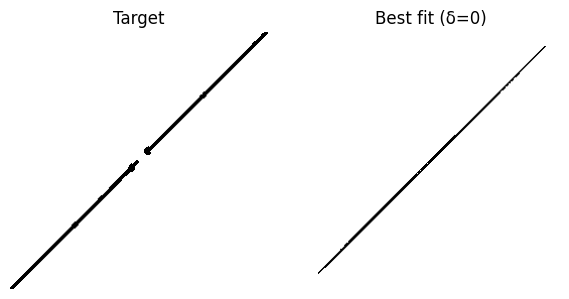

In [42]:
# 연속 최적화
refined = refine_ab_delta0(target_img, coarse['a'], coarse['b'], tmax=2*np.pi)
print(f"[Refined] a≈{refined['a']:.3f}, b≈{refined['b']:.3f}, SSIM={refined['score']:.4f}")

# 분수비/SSIM 출력
ratio_txt, (p, q), r_float = pretty_ratio(refined['a'], refined['b'], max_den=40)
print(f"\nEstimated ratio ≈ {ratio_txt}  (~ {r_float:.4f})")
print(f"SSIM ≈ {refined['score']:.4f}")
print("Match ≥ 0.90 ?", refined['score'] >= 0.90)

# 시각화: 타깃 vs 추정 결과
best_img = draw_lissajous_image(refined['a'], refined['b'], size=target_img.shape[0])
fig, axes = plt.subplots(1,2, figsize=(6,3))
axes[0].imshow(target_img, cmap='gray'); axes[0].set_title("Target"); axes[0].axis('off')
axes[1].imshow(best_img, cmap='gray'); axes[1].set_title("Best fit (δ=0)"); axes[1].axis('off')
plt.tight_layout(); plt.show()
